6/29/2024\
Author: Michael Stoll\
\
In this assignment, I am going to be using the basic wine quality dataset that we've been working with since the beginning of the class. The objective here is to find both the best regression model, as well as the best hyperparameters for that regression model, to predict the quality of a given bottle of red wine.\
First I need to do a bit of setup. That, of course, first involves importing the dataset.

In [1]:
import numpy as np
import pandas as pd
from numpy import float32
data = pd.read_csv("winequality-red.csv", sep=',')
#data = data.astype(float32)
data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Now that we know it's properly imported, I'm going to display a correlation heatmap, just as a refresher of how well the different features correlate to one another.

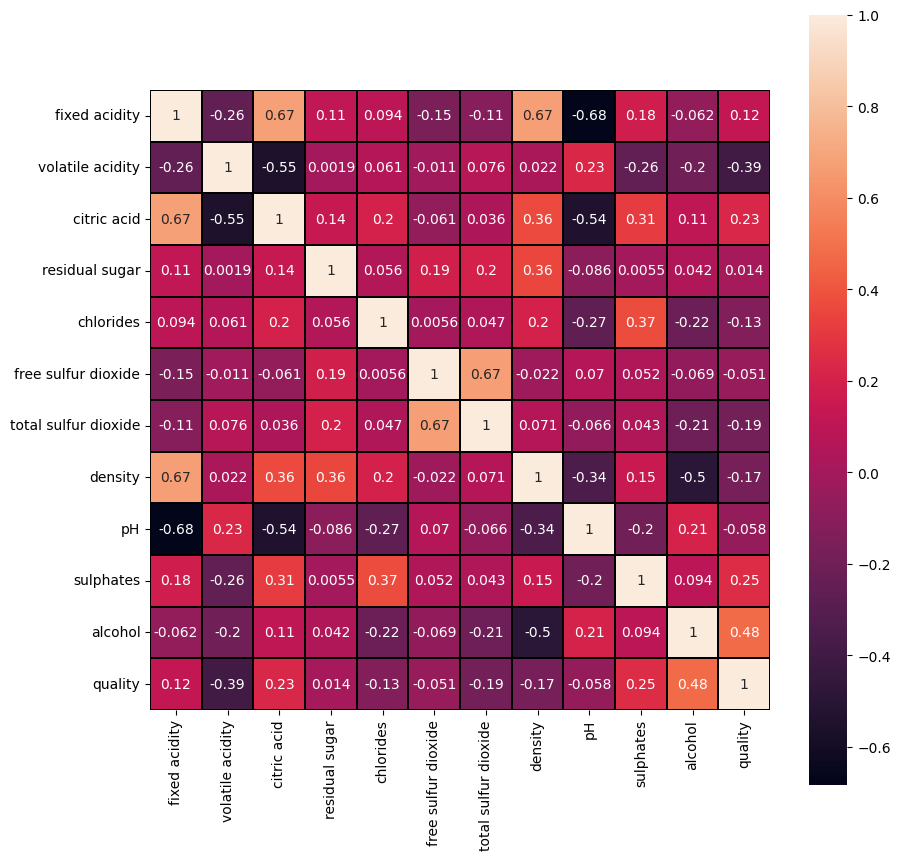

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

It's clear from this simple heatmap that there won't be a perfect accuracy, but that's not the point. All that I'm trying to do is get as close as possible.\
Now it's time to split off the training data from the testing data. You'll notice a type conversion here; that's simply because I don't have any reason to be working with the default float64 data type and it was actually causing major issues in the Bayesian step by exceeding my available memory. So we'll keep these values as float32's.

In [3]:
from sklearn.model_selection import train_test_split
from numpy import float32
features = data.drop(columns=['quality'])
target = data['quality']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state= 721)


The data has been properly split, and all is well and truly random for this iteration: however, for once, we are going to be doing many iterations, so I want to ensure that we stay away from overfitting, meaning that one truly random representation of the data will not be enough. To help aid me in this task of resampling, I've created this function that literally just shuffles and resplits the data into training and test sets.

In [4]:
#nested resampling
from sklearn.utils import shuffle
def mix():
    shuffle(features)
    shuffle(target)
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state= 721)

    

While I'm writing functions to make things easier for me, I figured I might as well streamline the process of displaying the results as well.\
\
Build actually calculates the mean squared error, mean absolute error, and r squared scores of the data predicted by the model. Notably, it takes a boolean parameter as well, since I want to be able to use the same function for both the unoptimized and the optimized algorithms and intend to use those two in slightly different ways by returning the predicted data to the unoptimized usages and the fitted model to the optimized usages.\
\
Plot is exactly what it sounds like. It simply generates a scatterplot that contrasts the predicted data against the actual data. In a perfect world, these points would fall along a line with a slope of 1. But this is no perfect world.

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def build(model, opt):
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    m2e = mean_squared_error(target_test, pred)
    mae = mean_absolute_error(target_test, pred)
    r2 = r2_score(target_test, pred)
    if(not opt):
        print("mean squared error for " + str(model) + " : " + str(m2e))
        print("mean absolute error: " + str(mae))
        print("r2 score: " + str(r2))
        return pred
    else:
        print("mean squared error for optimized model: " + str(m2e))
        print("mean absolute error: " + str(mae))
        print("r2 score: " + str(r2))
        return model

def plot(model,pred):
    plt.scatter(pred, target_test, color='blue')
    plt.title(str(model))
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.grid(True)
    plt.show()

Now it's time to build search spaces so that there is something to optimize. Given that the random search and the Bayesian search use the same parameters, I'm going to build the same search spaces for both.\
\
This also happens to be, of course, where I have to make the determination for which regressions I'm going to use. For now, I've selected the random forest regressor, the support vector regressor, the decision tree regressor, and the gradient boosting regressor. I'm loading the functions themselves into one list, and the search spaces into another, for reasons that will become clear in the next step.\
\
For each of these regressors, I found a list of parameters that I felt was thorough but not so intense as to be noncomputable. For example, I could give the random forest regressor a list of estimators that ranges from 100,100000 just to see what would happen, but given that I'm already taking 900 * 3 * 18 * 5 = 243,000 potential computations (not including the number of iterations or cross validations that are upcoming), I thought that range(100,1000) would probably do the trick. I've well exceeded the reasonable capacities of grid search, in my humble opinion.

In [6]:
#build search spaces
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


estimators = list(range(100,1000))
maxFeatures = ['sqrt', 'log2', None]
minSplit = list(range(2,20))
minLeaf = list(range(1,5))
randomGrid = {'n_estimators':estimators, 'max_features':maxFeatures, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

maxIter = list(range(100,1000))
gamma = ['scale', 'auto']
degree = list(range(3,16))
svcGrid = {'max_iter':maxIter, 'gamma':gamma, 'degree':degree}

splitter = ['best', 'random']
maxDepth = list(range(3,115))
dtGrid = {'splitter':splitter, 'max_depth':maxDepth, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

gbGrid = {'max_features':maxFeatures, 'min_samples_leaf':minLeaf, 'min_samples_split':minSplit}

space = [svcGrid, dtGrid, gbGrid, randomGrid]
models = [SVR(), DecisionTreeRegressor(), GradientBoostingRegressor(),RandomForestRegressor()]

With the initialization taken care of, it's finally time to begin the searching.\
\
The first thing I want to point out is the RandomizedSearchCV function's parameters. "model" and "space" should be pretty self explanatory, even though there is some strange syntax going on with subscripting "space" (this is just to ensure that the model and space lists iterate at the same rate so that the correct search space is used for each regressor). "n_iter" and "scoring" ought to be straightforward as well, but there could understandably be some confusion regarding "n_jobs" and "cv".\
n_jobs is just the amount of processors that the environment will utilize from your machine. Since I've set it to -1, it will use all of the processing power my machine has to offer. God knows it will need it.\
"cv" is potentially the most interesting of the parameters. CV, you might guess, stands for cross validation, and by providing the value "5" I'm requesting that for every iteration, the search function cross validates 5 times. Given that earlier mix() function working at one loop level higher than this, with this step we achieve nested resampling, and all is well in the world.\
\
The other thing that I want to talk about is a higher-level, broad description of the function. It's a bit messy, of course, but I'm at the stage in reworking it where I'm afraid to touch anything, lest I make it not work again. So instead, a (not so) brief overview:\
When the function runs the first time, the randScore, randName, and bestRandParams variables are set to a default value. In each iteration of the loop (4 total), after shuffling the data, the default parameters for the given model are evaluated and graphed (purely for reference in the next step). Then a clock is started and the randomized search function does its thing, after which it returns a version of the model with the best parameters it could find in the allotted number of iterations. That model is then evaluated and graphed as well, then after that is done the r squared score of that model is compared against randScore, which holds the previous best r squared score. If the current score is better than the stored one, the storage is overwritten with the new reigning score, name, and parameter list. After the loop has run 4 times, it exits and prints the winner's data.

mean squared error for SVR() : 0.5764583085381073
mean absolute error: 0.5780251410024956
r2 score: 0.16222919678821757


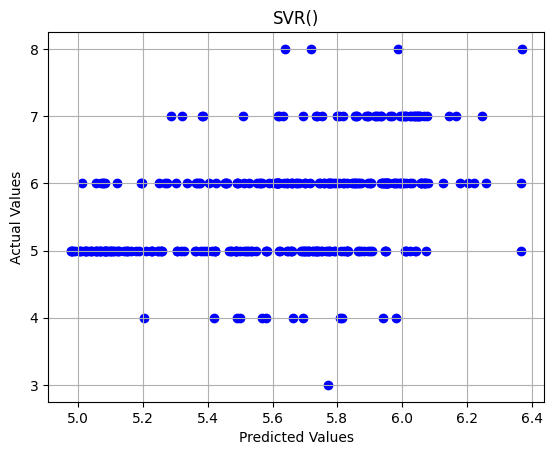

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=846).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


mean squared error for optimized model: 0.5131222434408439
mean absolute error: 0.5476630458358376
r2 score: 0.25427593346093647


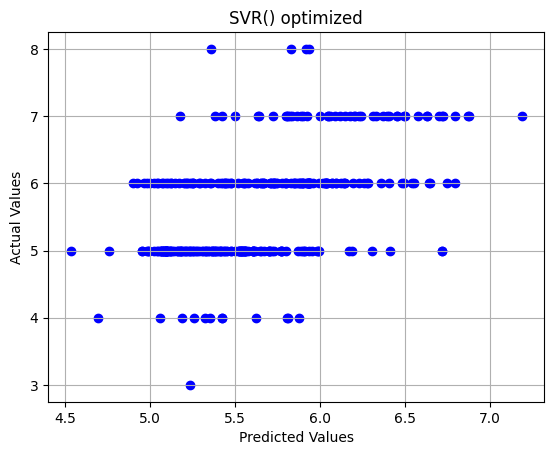

process took 61.504024505615234 seconds.

mean squared error for DecisionTreeRegressor() : 0.603125
mean absolute error: 0.434375
r2 score: 0.1234743116661936


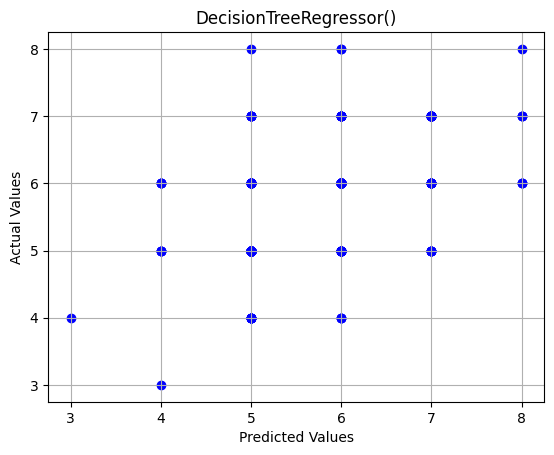

mean squared error for optimized model: 0.4867126605477575
mean absolute error: 0.5493155560743535
r2 score: 0.29265716094109606


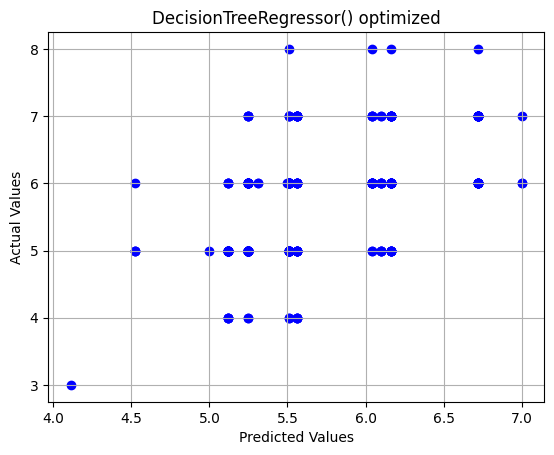

process took 6.661082983016968 seconds.

mean squared error for GradientBoostingRegressor() : 0.37878143780256607
mean absolute error: 0.47744438577706516
r2 score: 0.4495143452883513


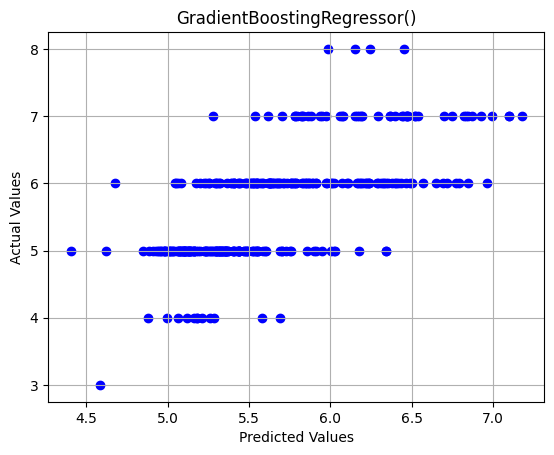

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 216 is smaller than n_iter=500. Running 216 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


mean squared error for optimized model: 0.3795079887905598
mean absolute error: 0.47893381204356383
r2 score: 0.44845844376733857


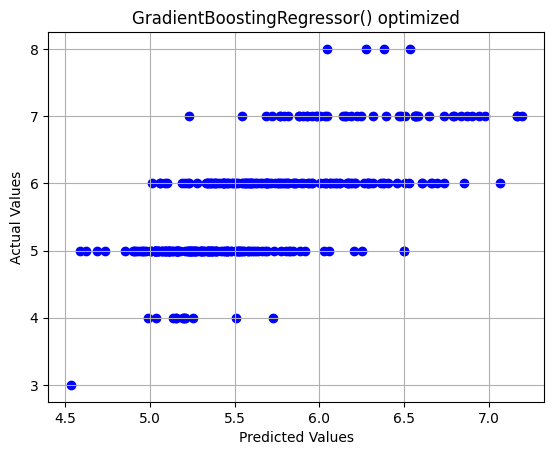

process took 62.63418412208557 seconds.

mean squared error for RandomForestRegressor() : 0.33213875000000004
mean absolute error: 0.415125
r2 score: 0.517300482543287


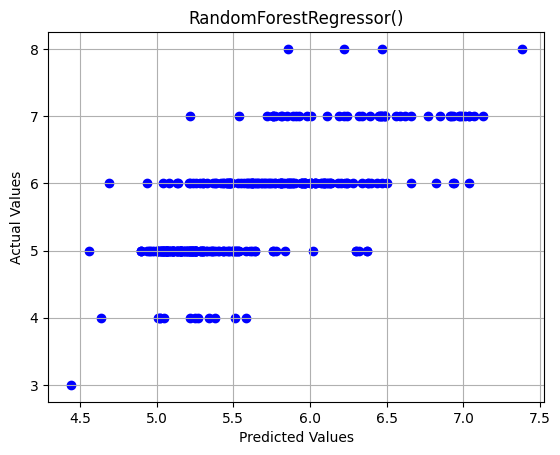

mean squared error for optimized model: 0.32516187764592575
mean absolute error: 0.4156585120643432
r2 score: 0.5274400188625774


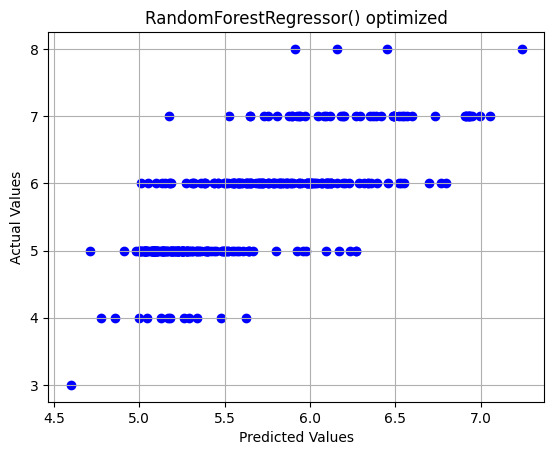

process took 1993.3977437019348 seconds.


The best performing model was RandomForestRegressor() with the parameters {'n_estimators': 746, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} and an r2 score of 0.5274400188625774


In [7]:
#randomized search
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV

randScore = 0
randName = ""
bestRandParams = ""
i = 0
for model in models:
    mix()
    pred = build(model, False)
    plot(model,pred)
    currentTime = time()
    search = RandomizedSearchCV(model, space[i], n_iter=500, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
    i = i + 1
    optModel = build(search, True) 
    optPred = optModel.predict(features_test)
    optr2 = r2_score(target_test, optPred)
    plot((str(model) + " optimized"), optPred)
    totalTime = time() - currentTime
    print("process took " + str(totalTime) + " seconds.\n")
    if(optr2 > randScore):
        randScore = optr2
        randName = model
        bestRandParams = optModel.best_params_
        

print("\nThe best performing model was " + str(randName) + " with the parameters " + str(bestRandParams) + " and an r2 score of " + str(randScore))

Clearly, there is a general trend towards a higher r squared score across these optimizations. A notable exception is the gradient boosting regressor, but that anomaly is less than a percent and is pretty easily explained by the random nature of the search. No one ever said that this was going to be the be all end all of searches. That's where Bayesian searching comes in, actually.\
\
The Bayesian search is a much more thorough process. As such, it takes much more time to run, but the result is also more accurate. It's sort of like taking the time to sight in a scope on a rifle and use a rangefinder to find the correct distance and calibrate a shot, versus just beginning to fire wildly towards the target and hope that you eventually find a bullseye. Sometimes it happens, but Bayesian optimization guarantees that that happens. So long as you have enough iterations, that is.

mean squared error for SVR() : 0.5764583085381073
mean absolute error: 0.5780251410024956
r2 score: 0.16222919678821757


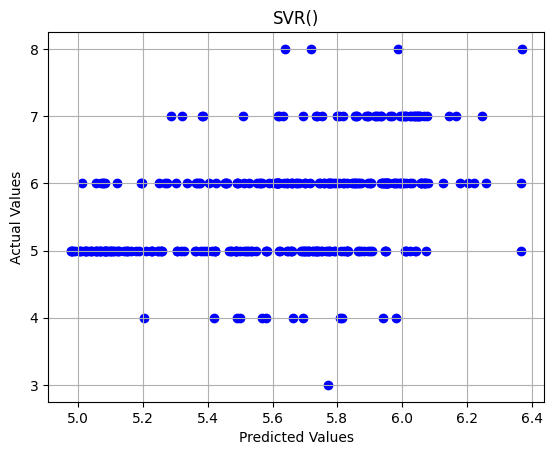

In [9]:
#bayesian opt
from skopt import BayesSearchCV

bayesScore = 0
bayesName = ""
bestBayesParams = ""
i = 0
for model in models:
    mix()
    pred = build(model, False)
    plot(model,pred)
    currentTime = time()
    if i==3:
        search = BayesSearchCV(model, space[i], n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
    else:
        search = BayesSearchCV(model, space[i], n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
    i = i + 1
    optModel = build(search, True) 
    optPred = optModel.predict(features_test)
    optr2 = r2_score(target_test, optPred)
    plot((str(model) + " optimized"), optPred)
    totalTime = time() - currentTime
    print("process took " + str(totalTime) + " seconds.\n")
    if(optr2 > bayesScore):
        bayesScore = optr2
        randName = model
        bestRandParams = optModel.best_params_
        

print("\nThe best performing model was " + str(randName) + " with the parameters " + str(bestRandParams) + " and an r2 score of " + str(randScore))